 About the problem
❤ Breast cancer is the most diagnosed cancer among women worldwide, accounting for 1 in 4 cancer cases.
❤ Breast cancer cells usually form a tumour that can often be seen on an x-ray or felt as a lump.

 
The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. Because we’re predicting for every pixel in the image, this task is commonly referred to as dense prediction. The output itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class.
Early Cancer Detection is a must to begin a fight against the cancer to stop it from spreading and affecting the different regions, further complicating the treatment effectiveness.
Out of all other cancers, Breast cancer is the most prevalent. In 2022, an estimated 287,500 new cases of invasive breast cancer will be diagnosed in women in the U.S. as well as 51,400 new cases of non-invasive (in-situ) breast cancer.
Hence, due to such an impact, it is necessary that we use any tool that helps us in early detection of cancer on set and try to get rid of it as soon as possible, saving numerous lives in the process.

Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes $:$ normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.
The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.
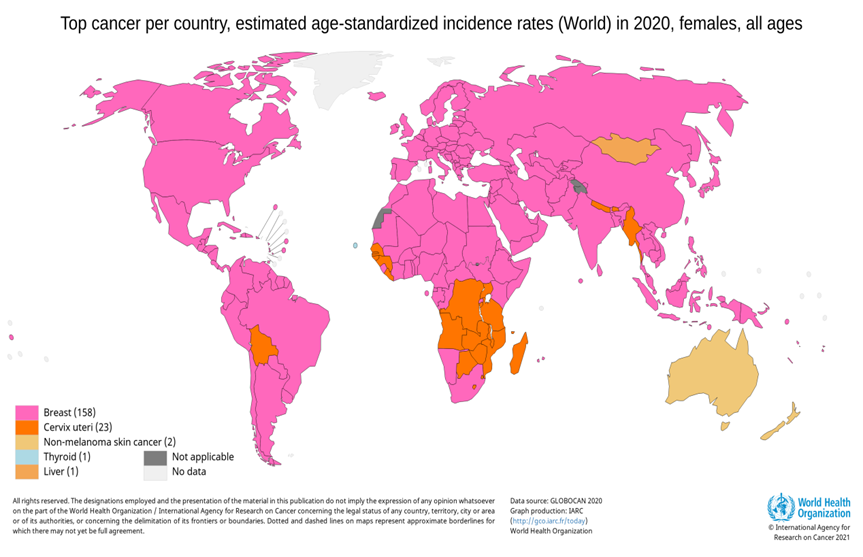


In [1]:
path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

# Libraries 

In [2]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
import timeit
import numpy as np 
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

# Reading to dataset

In [3]:
def num (image) :
    
    val = 0
    
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

In [4]:
#x for images 
#y for masks
#t for target"label"
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [5]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

In [6]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [7]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


# Important Function

convert image to one channel 

In [8]:
def convertToOneChannel(img):
   im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
   i=cv2.resize(im, (128, 128))
   return i

convert from one image to three channel 

In [9]:
   def convertToThreeChannel(img):
       b_np= np.array(img)
       g_np= np.array(img)
       r_np= np.array(img)
       final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
       return np.array(final_img)

# visualize image and mask from actual dataset

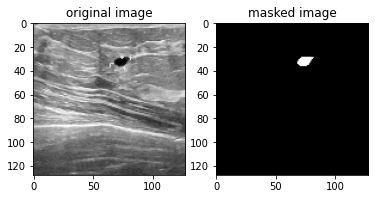

In [10]:
img=convertToThreeChannel(X[10])
mask=convertToThreeChannel(y[10])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

# Data Augmentation 

In [11]:
actual=[]
mask=[]
for i in X:
  horizontal_flip = cv2.flip(i, 1)
  vertical_horizontal_flip = cv2.flip(i, -1)
  imagerotate = cv2.rotate(i, cv2.ROTATE_180) 
  imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
  imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
  actual.append(horizontal_flip)
  actual.append(vertical_horizontal_flip)
  actual.append(imagerotate)
  actual.append(imagerotate1)
  actual.append(imagerotate2)
  

for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)

In [12]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [13]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

2.0
0.0


In [14]:
mask[mask > 1.0] = 1.0

In [15]:
print(mask.max())
print(mask.min())


1.0
0.0


In [16]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [17]:
t1=np.full(2185,1) 
t2=np.full(665,0)
t3=np.full(1050,2)  
T=np.concatenate((t1, t2, t3), axis = 0)
T=np.array(T)

In [18]:
print(T.shape)

(3900,)


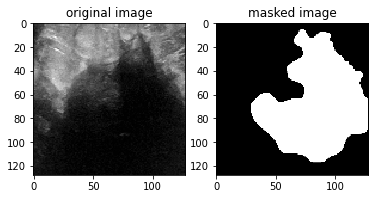

In [19]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title("masked image")
plt.show()

# data split

In [20]:

X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.15, random_state = 1)


In [21]:
actual1=[]
for i in actual:
  actual1.append(convertToThreeChannel(i) )
mask1=[]
for i in mask:
  mask1.append(convertToThreeChannel(i) )
actual1=np.array(actual1)
mask1=np.array(mask1)

In [22]:
print(X_train.shape)
print(X_test.shape)

(3315, 128, 128)
(585, 128, 128)


<img src = "https://miro.medium.com/max/3600/1*f7YOaE4TWubwaFF7Z1fzNw.png"/>

# Build Unet Biomedical Model 

In [23]:
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

2022-12-17 12:16:24.281229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:16:24.282305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:16:24.609858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:16:24.610785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:16:24.611603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [24]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

In [25]:
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [26]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

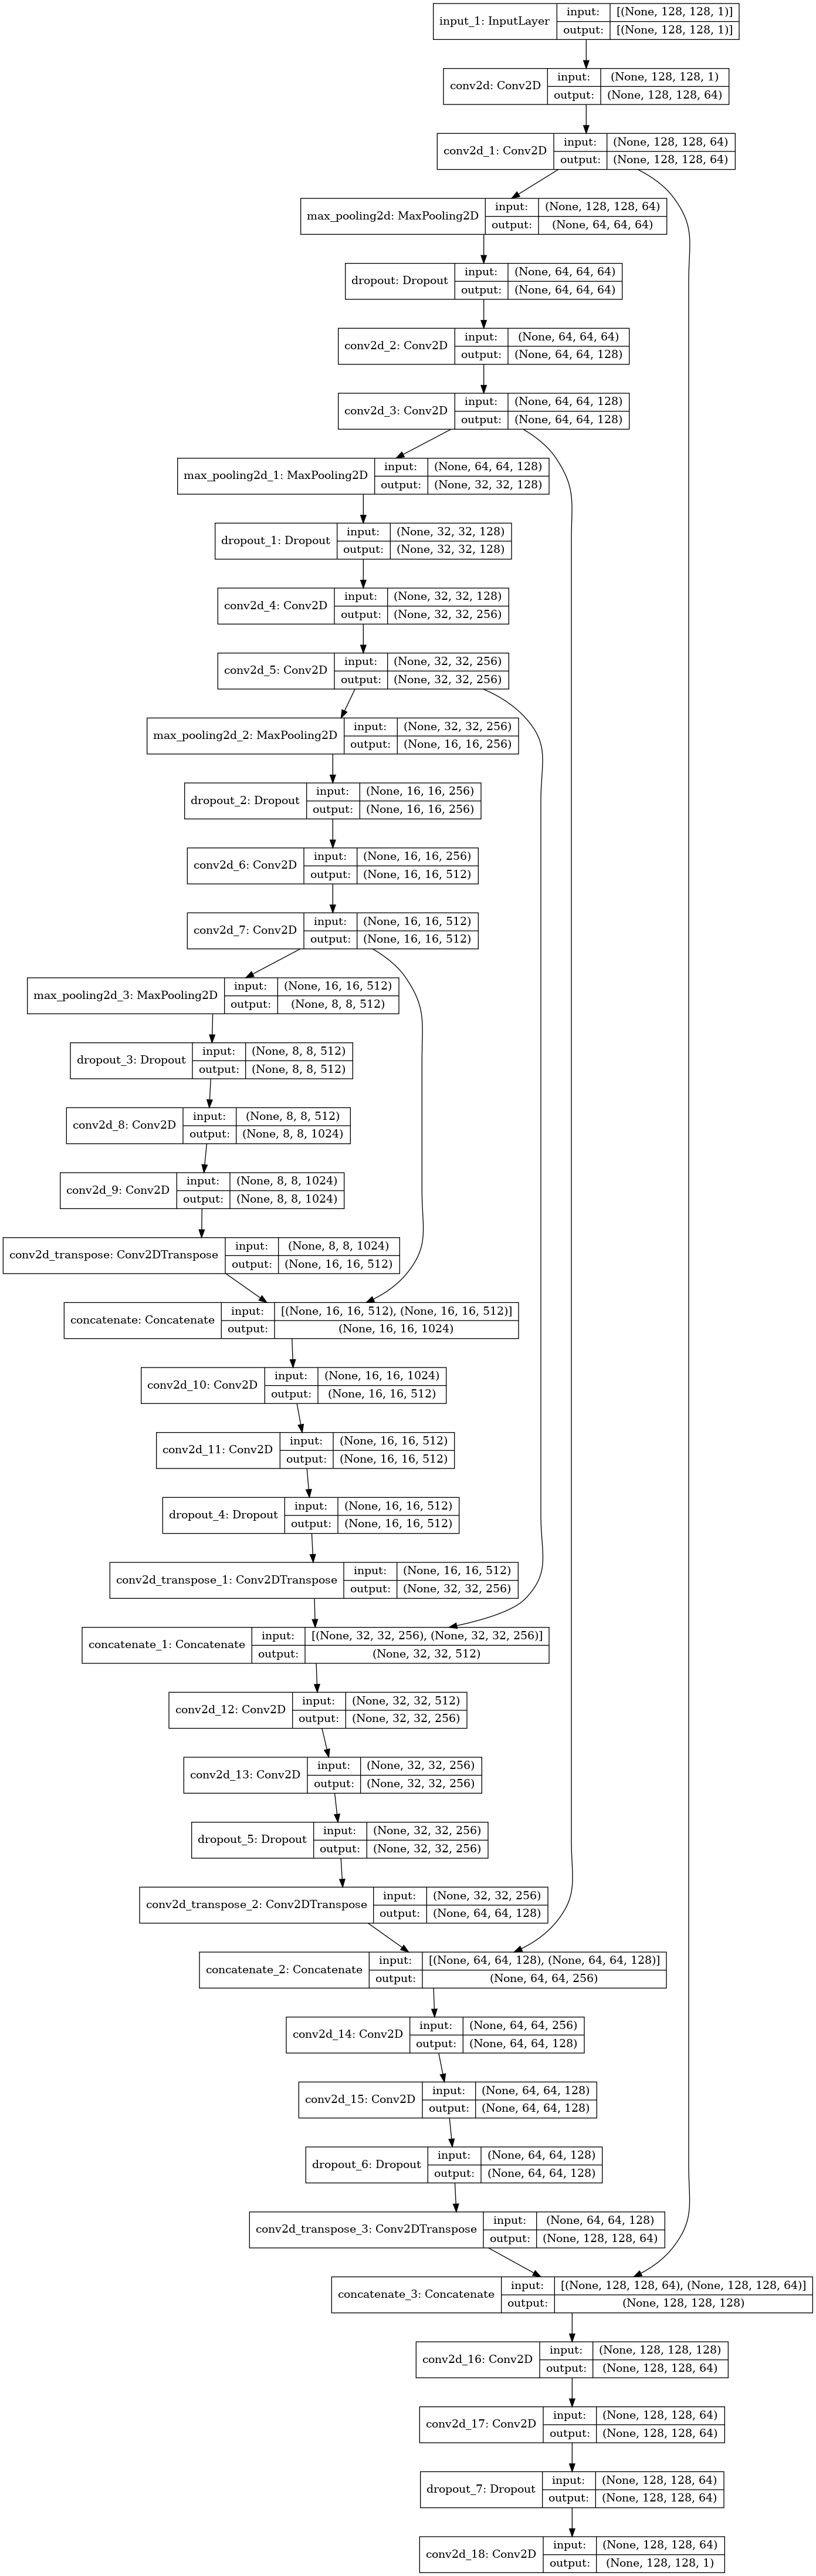

In [27]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

In [28]:
from keras.metrics import MeanIoU


In [29]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['acc'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [30]:
from keras.callbacks import ModelCheckpoint

In [31]:
checkp = ModelCheckpoint('./unet_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

In [32]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 16, validation_data = (X_test, y_test), callbacks = [checkp])

2022-12-17 12:16:33.307094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-17 12:16:36.607868: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


208/208 [==============================] - 67s 232ms/step - loss: 0.0680 - acc: 0.9208 - val_loss: 0.0603 - val_acc: 0.9293
Epoch 2/100
208/208 [==============================] - 44s 212ms/step - loss: 0.0535 - acc: 0.9315 - val_loss: 0.0432 - val_acc: 0.9442
Epoch 3/100
208/208 [==============================] - 46s 219ms/step - loss: 0.0462 - acc: 0.9396 - val_loss: 0.0394 - val_acc: 0.9494
Epoch 4/100
208/208 [==============================] - 46s 221ms/step - loss: 0.0430 - acc: 0.9438 - val_loss: 0.0402 - val_acc: 0.9474
Epoch 5/100
208/208 [==============================] - 46s 220ms/step - loss: 0.0400 - acc: 0.9484 - val_loss: 0.0336 - val_acc: 0.9567
Epoch 6/100
208/208 [==============================] - 46s 220ms/step - loss: 0.0365 - acc: 0.9532 - val_loss: 0.0317 - val_acc: 0.9588
Epoch 7/100
208/208 [==============================] - 46s 219ms/step - loss: 0.0337 - acc: 0.9570 - val_loss: 0.0283 - val_acc: 0.9636
Epoch 8/100
208/208 [==============================] - 46s 2

# visualize Accuracy and loss Graph

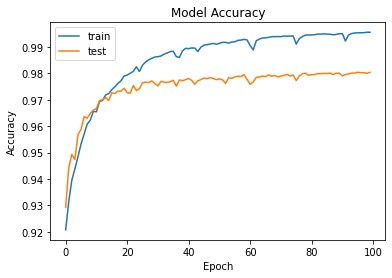

In [33]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

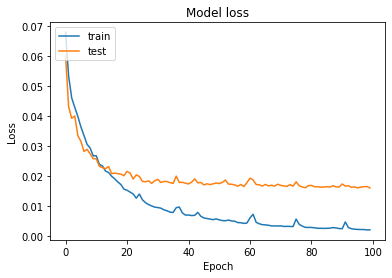

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# calculate accuracy and loss 

In [35]:
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

19/19 [==============================] - 8s 111ms/step - loss: 0.0162 - acc: 0.9804
Test loss: 0.016183430328965187
Test accuracy: 98.03835153579712


# save model 

In [36]:
model.save("finalunet.h5")

# test model 

In [37]:
def imgpredicting(img):
 x=[]
 x.append(img)
 x=np.array(x)
 output=model.predict(x)
 #print(output)
 output=np.array(output)
 output.shape
 array = np.reshape(output[0], (128, 128))
 print(array.shape)
 return array

(128, 128)


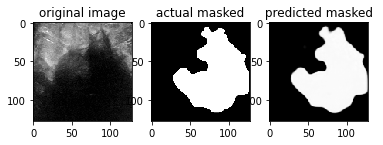

In [38]:

plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[3000]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()


(128, 128)


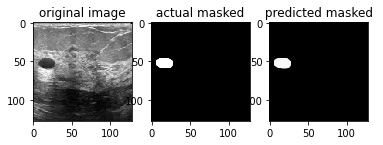

In [39]:

plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[500],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[500],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[500]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()


(128, 128)


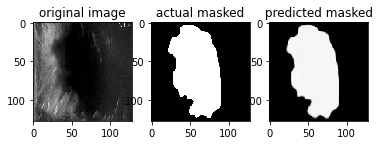

In [40]:

plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[3888],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[3888],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[3888]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()


In [41]:
score, acc = model.evaluate(X_test, y_test,batch_size=32)

print('Test score:', score)

print('Test accuracy:', acc)

19/19 [==============================] - 2s 112ms/step - loss: 0.0162 - acc: 0.9804
Test score: 0.016183430328965187
Test accuracy: 0.9803835153579712


# Classifier

In [130]:
info = [
    'benign'   ,  # 0
    'normal'   ,  # 1
    'malignant',  # 2
  
]

In [131]:
path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

In [132]:
import cv2
import numpy as np
# from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image as Img
from PIL import ImageTk
X = []
y = []
xgray=[]

label_num = -1

for label_class in os.listdir(path) :
    
    new_path   = path + label_class
    label_num += 1
    
    for img in os.listdir(new_path) :
        if 'mask' not in img :
            
            y.append(label_num)
            xg = cv2.imread(path + label_class +'/'+img, cv2.IMREAD_GRAYSCALE)
            x = cv2.imread(path + label_class +'/'+img,)
            X.append(img_to_array(Img.fromarray(cv2.resize(x, (128,128)))))
            xgray.append(img_to_array(Img.fromarray(cv2.resize(xg, (128,128)))))

In [133]:
X = np.array(X)
y = np.array(y)

In [134]:
X/= 255.0
xgray=np.array(xgray)
xgray/=255.0

In [135]:
from tensorflow.keras.utils import to_categorical

In [136]:
y = to_categorical(y)

In [137]:
print(X.shape)
print(y.shape)

(780, 128, 128, 3)
(780, 3)


In [138]:
print(X.min())
print(X.max())

0.0
1.0


(-0.5, 127.5, 127.5, -0.5)

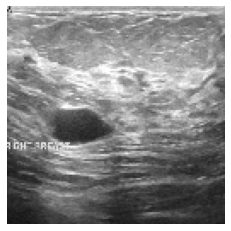

In [139]:
plt.imshow(np.squeeze(X[0]), 'gray')
plt.axis('off')

In [140]:
from keras.models import load_model

In [141]:
localize = load_model("finalunet.h5")

In [142]:
M = localize.predict(xgray )

0.0
1.0634456


(-0.5, 127.5, 127.5, -0.5)

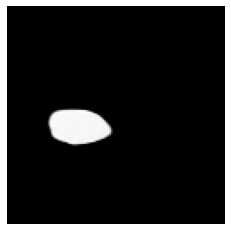

In [143]:
print(M.min())
print(M.max())

plt.imshow(np.squeeze(M[0]), 'gray')
plt.axis('off')

In [144]:
import pandas
import seaborn

Text(0.5, 1.0, 'Distribution of classes accross the entire dataset')

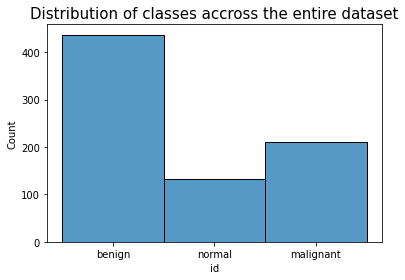

In [145]:
seaborn.histplot(data = pandas.DataFrame({'id' : [info[p] for p in np.argmax(y, axis = 1)]}), x = 'id')
plt.title('Distribution of classes accross the entire dataset', fontsize = 15)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = 1)

In [147]:
print(X_train.shape)
print(y_train.shape)

(702, 128, 128, 3)
(702, 3)


In [148]:
print(X_test.shape)
print(y_test.shape)

(78, 128, 128, 3)
(78, 3)


In [149]:
from numpy.random import randint

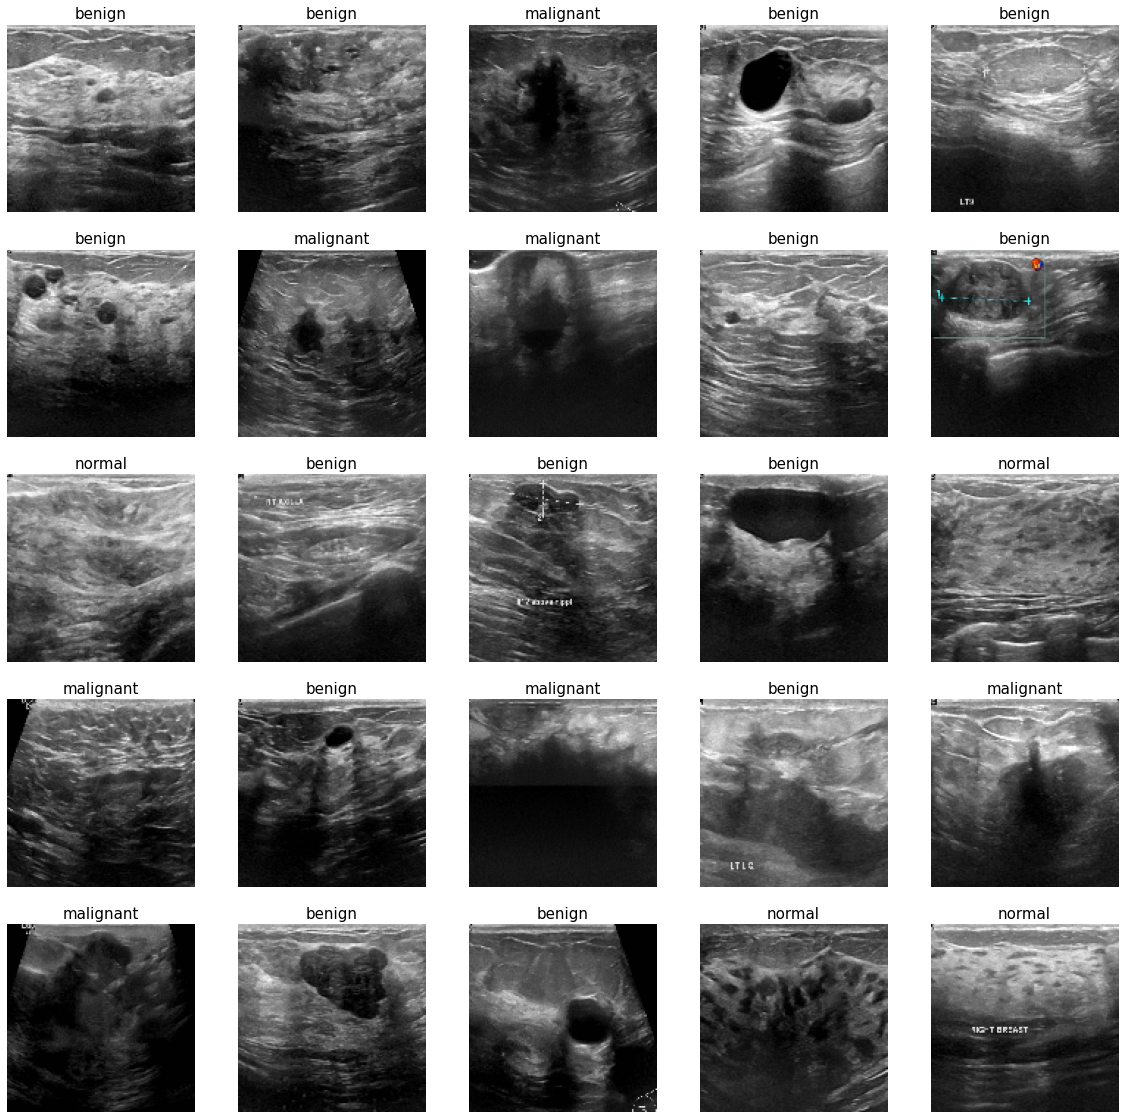

In [150]:
plt.figure(figsize = (20,20))
i = 0
SIZE = 702
while i < 25 :
    
    x = randint(0, SIZE)
    plt.subplot(5,5,i+1)
    plt.imshow(np.squeeze(X_train[x]), 'gray')
    plt.title(f'{info[np.argmax(y_train[x])]}', fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

# Data augmentation

In [151]:
from keras.preprocessing.image import ImageDataGenerator

In [152]:
train_gen = ImageDataGenerator(horizontal_flip = True, rotation_range = 15, width_shift_range = [-10, 10], height_shift_range = [-10, 10], zoom_range = [0.80, 1.00])

In [153]:
train_gen.fit(X_train)

In [154]:
pointer = train_gen.flow(X_train, y_train)

In [155]:
trainX, trainy = pointer.next()

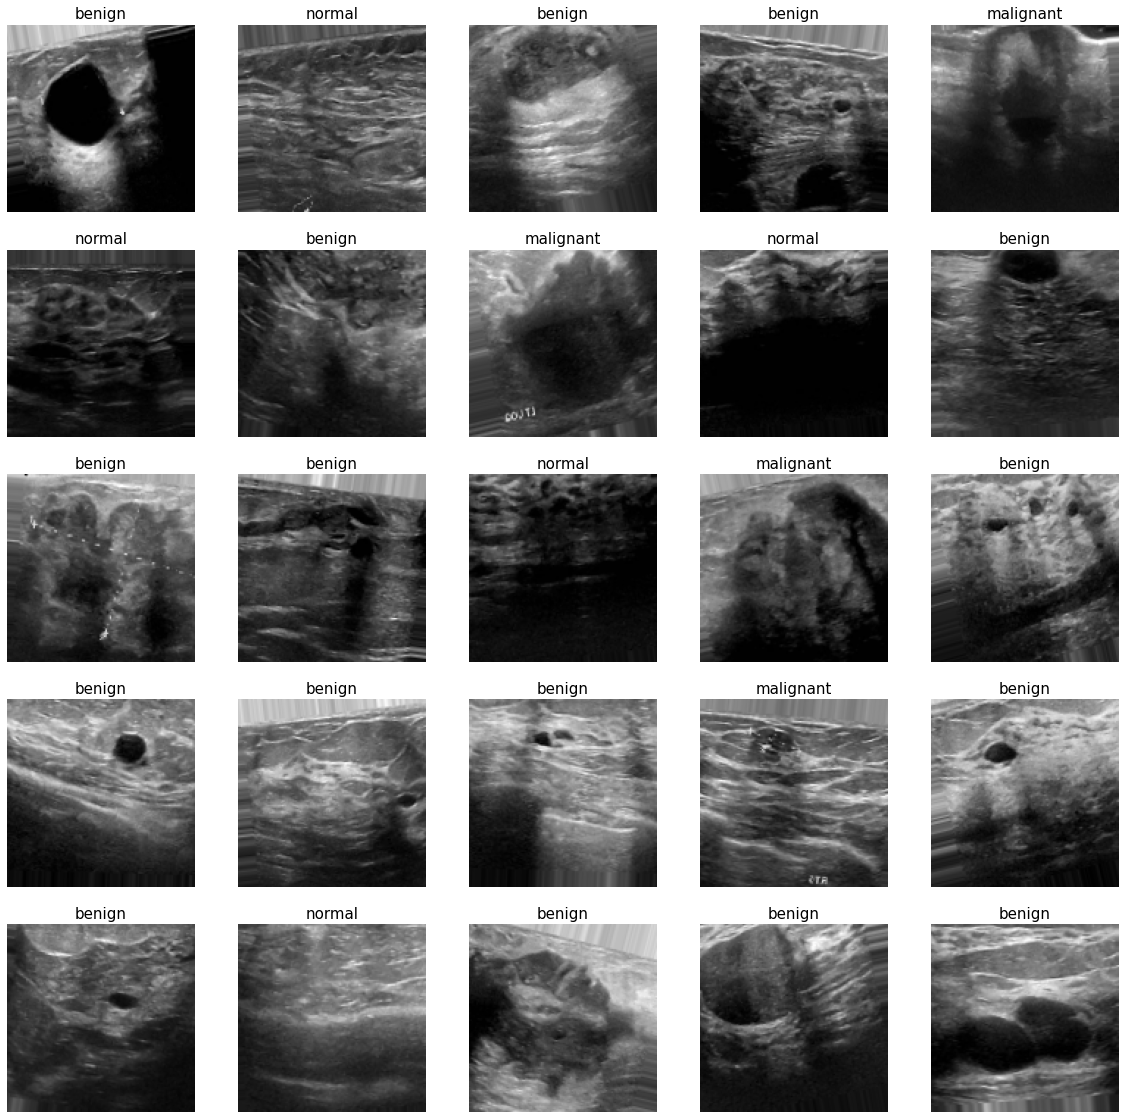

In [156]:
plt.figure(figsize = (20,20))

i = 0

while i < 25 :
    
    plt.subplot(5, 5, i+1)
    plt.imshow(np.squeeze(trainX[i]), 'gray')
    plt.title(f'{info[np.argmax(trainy[i])]}', fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

# make CNN model

In [157]:
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.layers import Flatten
from keras.layers import Dense
from IPython.display import Image, display
# preprocessing and processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# ploting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow.keras.utils import plot_model
# split data
from sklearn.model_selection import train_test_split
# CNN
from keras import models, layers
# val
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [158]:

from tensorflow.keras.optimizers import SGD

from keras.callbacks import EarlyStopping,ModelCheckpoint

from keras.layers import MaxPool2D


In [159]:
vgg19 = keras.applications.vgg19
conv_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(128,128,3))
for layer in conv_model.layers: 
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(.2)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(.2)(x)
x = keras.layers.Dense(132, activation='relu')(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['accuracy'],)

history = full_model.fit(train_gen.flow(X_train, y_train, batch_size =32), epochs = 400, validation_data = (X_test, y_test),   workers=10, callbacks = [checkp])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


22/22 [==============================] - 5s 141ms/step - loss: 0.8722 - accuracy: 0.6140 - val_loss: 0.9628 - val_accuracy: 0.5641

Epoch 00001: val_accuracy did not improve from 0.84615
Epoch 2/400
22/22 [==============================] - 3s 87ms/step - loss: 0.7469 - accuracy: 0.6880 - val_loss: 0.8894 - val_accuracy: 0.5897

Epoch 00002: val_accuracy did not improve from 0.84615
Epoch 3/400
22/22 [==============================] - 3s 80ms/step - loss: 0.6725 - accuracy: 0.7137 - val_loss: 0.8761 - val_accuracy: 0.6154

Epoch 00003: val_accuracy did not improve from 0.84615
Epoch 4/400
22/22 [==============================] - 3s 78ms/step - loss: 0.6510 - accuracy: 0.7151 - val_loss: 0.8379 - val_accuracy: 0.5897

Epoch 00004: val_accuracy did not improve from 0.84615
Epoch 5/400
22/22 [==============================] - 3s 82ms/step - loss: 0.6689 - accuracy: 0.7222 - val_loss: 0.7951 - val_accuracy: 0.6667

Epoch 00005: val_accuracy did not improve from 0.84615
Epoch 6/400
22/22 [==

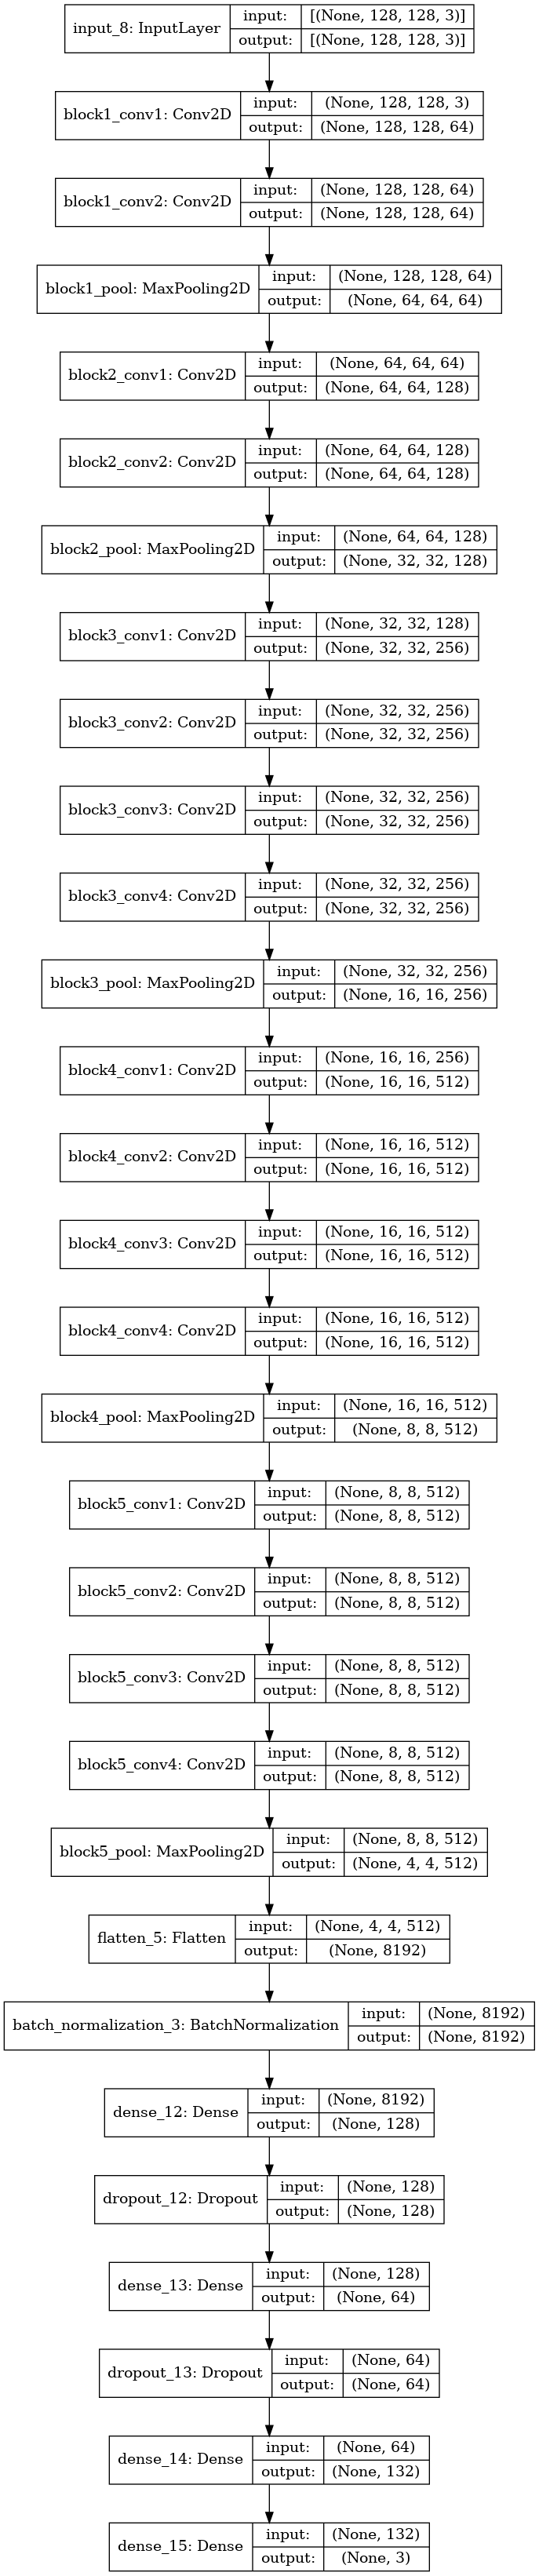

In [160]:
plot_model(full_model, 'cancer_classify.png', show_shapes = True)

# fit()

In [161]:
checkp = ModelCheckpoint('./valid_classifier.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1)

Text(0.5, 1.0, 'Loss val wrt. Epochs')

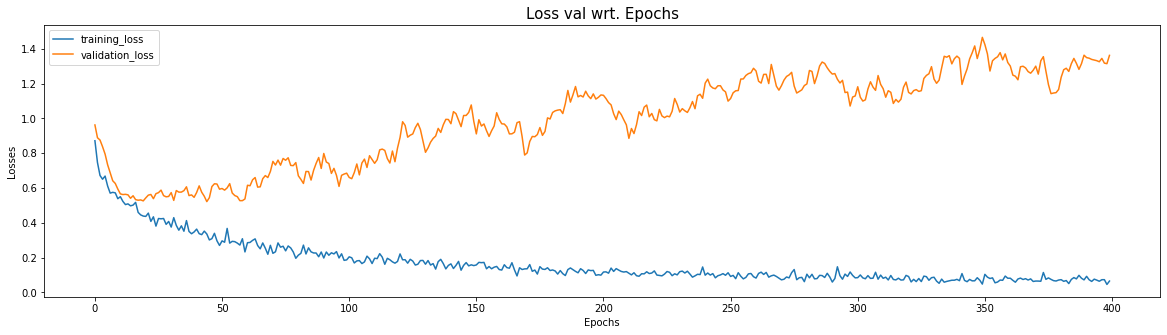

In [162]:
plt.figure(figsize = (20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss val wrt. Epochs', fontsize = 15)

In [163]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [164]:
model = keras.models.load_model('./valid_classifier.h5')

In [165]:
y_pred = model.predict(X_test)

In [166]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [167]:
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
# print(classification_report(y_test, y_pred, target_names = info))
print(classification_report(y_test, y_pred))

Accuracy : 0.8589743589743589
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        42
           1       0.86      0.75      0.80        16
           2       0.84      0.80      0.82        20

    accuracy                           0.86        78
   macro avg       0.86      0.83      0.84        78
weighted avg       0.86      0.86      0.86        78



In [168]:
cm = confusion_matrix(y_test,y_pred)

Text(0.5, 145.31999999999996, 'Predicted')

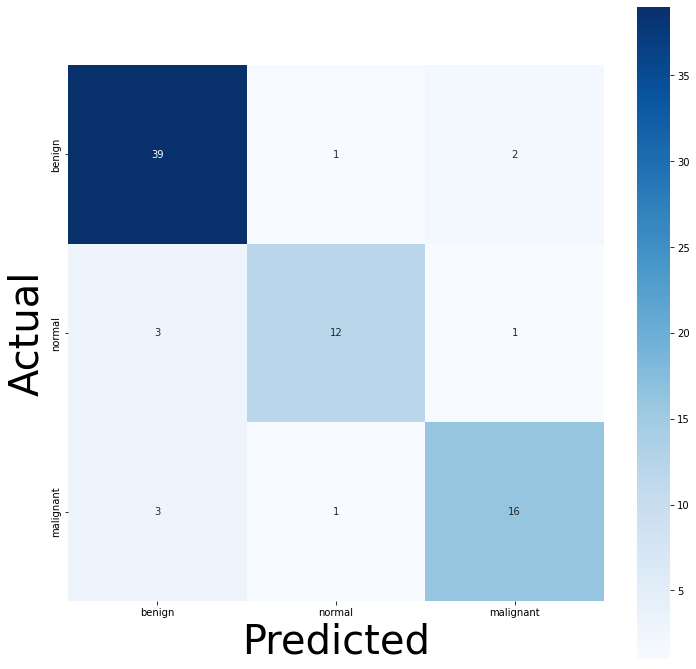

In [169]:
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [170]:
from keras.models import load_model

In [171]:
classifier = load_model('./valid_classifier.h5')
localize = load_model("finalunet.h5")

In [172]:
print(X.shape)
print(f'Minimum : {X.min()}')
print(f'Maximum : {X.max()}')

(780, 128, 128, 3)
Minimum : 0.0
Maximum : 1.0


(-0.5, 127.5, 127.5, -0.5)

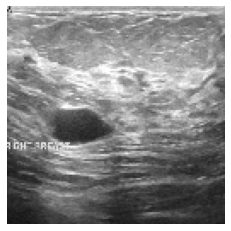

In [173]:
plt.imshow(np.squeeze(X[0]), 'gray')
plt.axis('off')

In [174]:
predY = localize.predict(xgray)

In [175]:
print(predY.shape)

(780, 128, 128, 1)


(-0.5, 127.5, 127.5, -0.5)

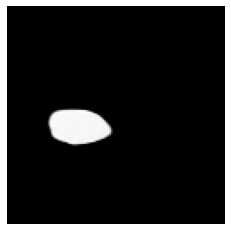

In [176]:
plt.imshow(np.squeeze(predY[0]), 'gray')
plt.axis('off')

In [177]:
print(predY.min())
print(predY.max())

0.0
1.0634456


In [178]:
pred_label = classifier.predict(X)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 

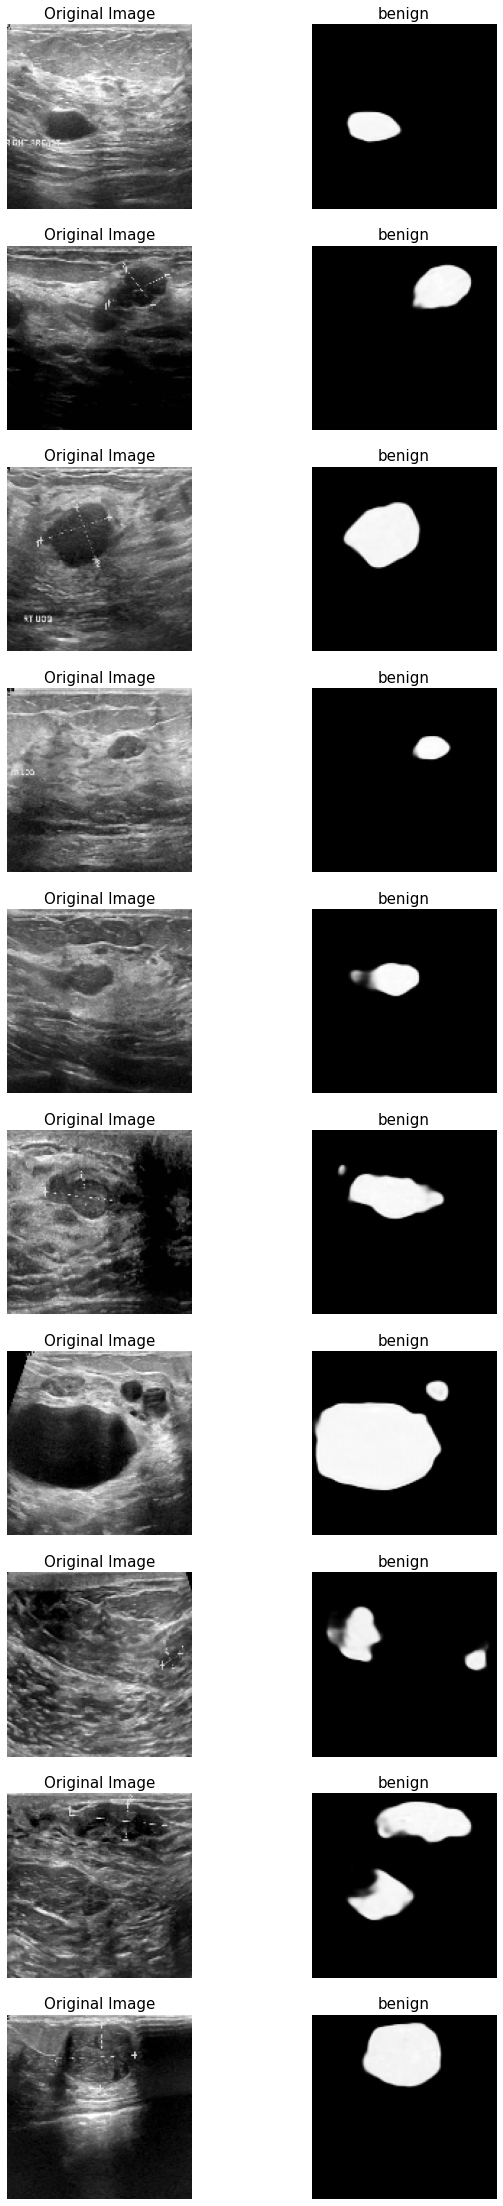

In [179]:
print(np.argmax(pred_label, axis = 1))
plt.figure(figsize = (10,40))

i = 0
j = 0
while i < 20 :
    
    plt.subplot(10,2,i+1)
    plt.imshow (np.squeeze(X[j]), 'gray')
    plt.title('Original Image', fontsize = 15)
    plt.axis('off')
    
    plt.subplot(10,2,i+2)
    plt.imshow (np.squeeze(predY[j]), 'gray')
    plt.title(f'{info[np.argmax(pred_label[j])]}', fontsize = 15)
    plt.axis('off')
    
    j += 1
    i += 2
plt.show()

##### 